# Simulated data experiment

## Initialize the environment

Load `gmf` library and set meta variables for displaying plots. `gmf` implements both Newton method and ALS method. It also loads the `gllvm` package with the Generalized Linear Latent Variable models. 

In [40]:
#library("devtools")
#install.packages("tidyr")
#install.packages(c("rockchalk","dplry"))
library("gmf")
library(ggplot2)
library("rockchalk")
library("gllvm")
library("dplyr")
library("raster")
library("tidyr")
options(repr.plot.width=4, repr.plot.height=4) # set the size of the plots
theme_set(theme_minimal(base_size = 15)) # choose a theme and large font for presentation clarity
fm = poisson()

## Generate data

In each experiment we:
* Generate a matrix
* Run GLLVM, Newton, and ALS methods
* Compute linear predictors

To generate the matrix we use a `gmf.simulate` function that generates regression variables $X$ and latent variables $U$. We also sample some coefficients $B$ and $V$ and define
$$M = X\beta + UV.$$
Finally, we sample $Y$ where each coefficient $Y[i,j]$ is a Poisson random variable with $\lambda_{i,j} = M[i,j]$.

Default parameters of `gmf.simulate` set the number of sites to $60$, the number of species to $60$, number of regression parameters to $2$, and the number of later factors to $2$.

In [23]:
experiment = function(i){
    d = 2
    tol = 1e-3
    
    data = gmf.simulate(n = 60, m = 60, d = d, p = 2)

    ptm <- proc.time()
    model.gllvm = gllvm(y = data$Y,
                        X = data$X,
                        formula = ~ .,
                        family="poisson",
                        num.lv = data$d,
                        reltol = tol)
    time.gllvm = proc.time() - ptm
    
    ptm <- proc.time()
    model.gmf.newton = gmf.newton(Y = data$Y, X = data$X, d = d,
                              gamma=0.5, maxIter = 1000,
                              family = fm,
                              method = "quasi",
                              tol = tol)
    time.gmf.newton = proc.time() - ptm
    
    ptm <- proc.time()
    model.gmf.airwls = gmf.newton(Y = data$Y, X = data$X, d = d,
                                gamma=0.1, maxIter = 100,
                                family = fm, 
                                parallel = 1,
                                method = "airwls",
                                tol = tol)
    time.gmf.airwls = proc.time() - ptm

    M.gllvm = residuals(model.gllvm)$linpred
    M.gmf.newton = model.gmf.newton$fit
    M.gmf.airwls = model.gmf.airwls$fit

    results = data.frame(true = c(data$M),
                         gllvm = c(M.gllvm),
                         newton = c(M.gmf.newton),
                         airwls = c(M.gmf.airwls))
    
    list(results = results,
         M.gllvm = M.gllvm,
         M.gmf.newton = M.gmf.newton,
         M.gmf.airwls = M.gmf.airwls,
         time.gllvm = time.gllvm[1],
         time.gmf.newton = time.gmf.newton[1],
         time.gmf.airwls = time.gmf.airwls[1],
         data = data)
}

We run the experiment 8 times on 8 cores. Adjust the values if you have a CPU with a smaller number of cores.

In [24]:
experiments = mclapply(1:8, experiment, mc.cores = 8)

In [25]:
get.results = function(x){
    res = c()
    for (i in 1:3) {
        res = c(res, gmf.deviance(pred = fm$linkinv(x$results[,i+1]),
                     obs = fm$linkinv(x$results[,1]),
                     family = fm))
    }
    res
}
get.time = function(x){
    c(x$time.gllvm, x$time.gmf.newton, x$time.gmf.airwls)
}
times = t(sapply(experiments, get.time))
colnames(times) = c("gllvm", "newton", "airwls")

results = data.frame(t(sapply(experiments, get.results)))
colnames(results) = c("gllvm", "newton", "airwls")
print(results)

print(times)

      gllvm    newton     airwls
1 0.1517021 0.1776360 0.14158710
2 0.1228106 0.1857731 0.21084831
3 0.1165573 0.1389183 0.22110644
4 0.1231533 0.1496335 0.13987233
5 0.1106750 0.1348406 0.09691917
6 0.2388848 0.1549913 0.11829467
7 0.1452654 0.1312505 0.12376487
8 0.1298972 0.1291177 0.11769024
     gllvm newton airwls
[1,] 6.134  0.096  1.121
[2,] 6.555  0.075  1.705
[3,] 6.876  0.087  1.605
[4,] 6.503  0.109  1.662
[5,] 6.559  0.092  1.992
[6,] 6.857  0.471  1.305
[7,] 7.067  0.158 16.384
[8,] 7.004  0.095  2.760


Finally, we gather results and compute statistics from the experiment.

In [26]:
results.long = results %>% gather(method, value, gllvm:airwls, factor_key=TRUE)
results.stats = results.long %>%
    group_by(method) %>% summarise(mean=mean(value), sd=sd(value))
results.stats

`summarise()` ungrouping output (override with `.groups` argument)



method,mean,sd
<fct>,<dbl>,<dbl>
gllvm,0.1423682,0.04138472
newton,0.1502701,0.02140811
airwls,0.1462604,0.04531653


## Results

Plot the results from all experiments.

Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”


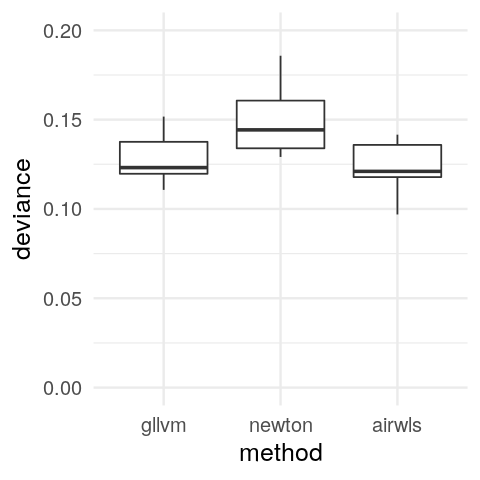

In [27]:
ggplot(results.long, aes(x = method, y = value)) + ylab("deviance") +
        ylim(c(0,0.2)) + geom_boxplot()

We can visually compare outputs from individual models. First, we plot the true $M$ matrix. next we plot residuals from each model

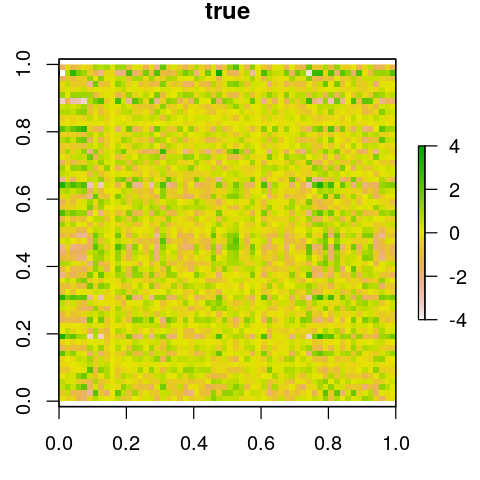

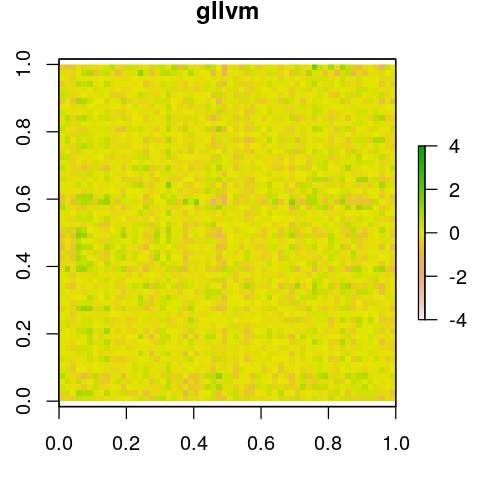

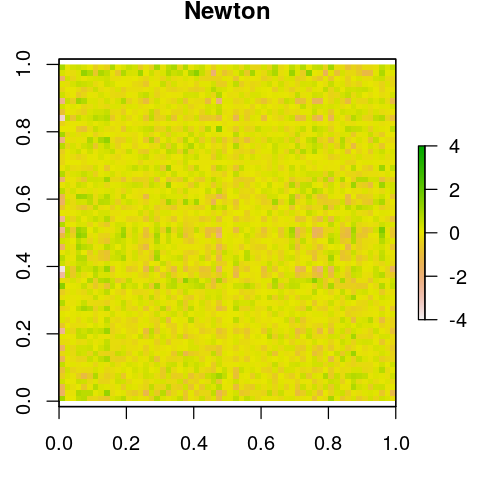

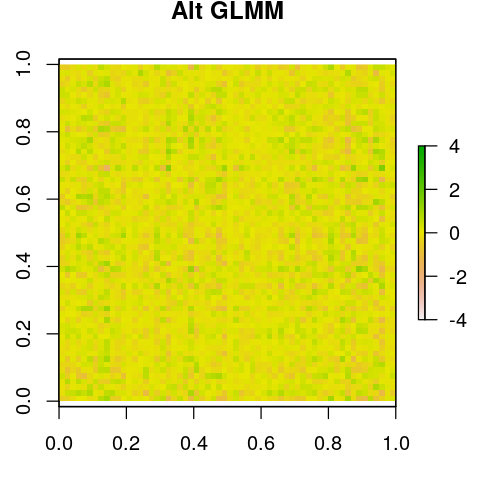

In [35]:
plot(raster(experiments[[1]]$data$M),zlim=c(-4,4))
title("true")
plot(raster(experiments[[1]]$M.gllvm - experiments[[1]]$data$M),zlim=c(-4,4))
title("gllvm")
plot(raster(experiments[[1]]$M.gmf.newton - experiments[[1]]$data$M),zlim=c(-4,4))
title("Newton")
plot(raster(experiments[[1]]$M.gmf.airwls - experiments[[1]]$data$M),zlim=c(-4,4))
title("Alt GLMM")

Compare `true` vs `predicted` lambdas.

gllvm correlation = 0.9205795

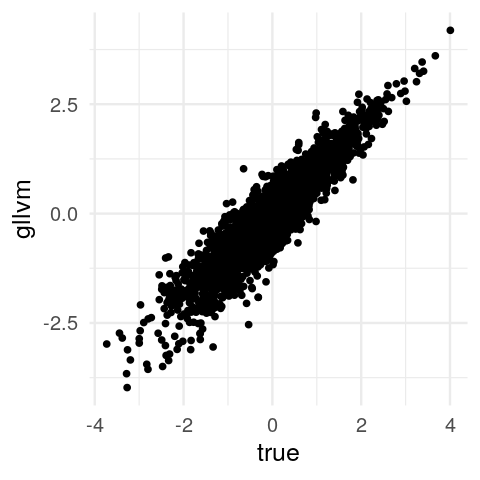

In [36]:
ggplot(experiments[[1]]$results, aes(x=true, y=gllvm)) + geom_point()
cat("gllvm correlation =",cor(c(experiments[[1]]$data$M),c(experiments[[1]]$M.gllvm)))

newton correlation = 0.8972119

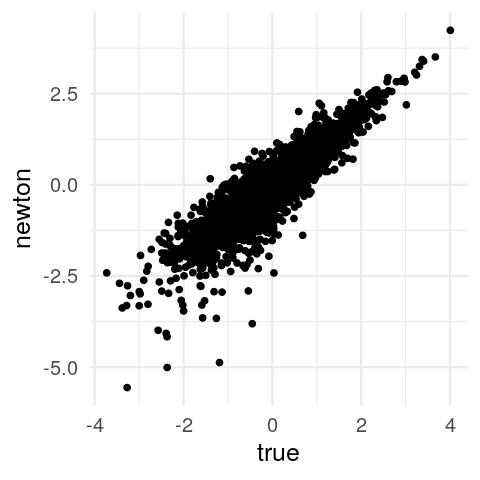

In [37]:
ggplot(experiments[[1]]$results, aes(x=true, y=newton)) + geom_point()
cat("newton correlation =",cor(c(experiments[[1]]$data$M),c(experiments[[1]]$M.gmf.newton)))

Alt GLMM correlation = 0.9273584

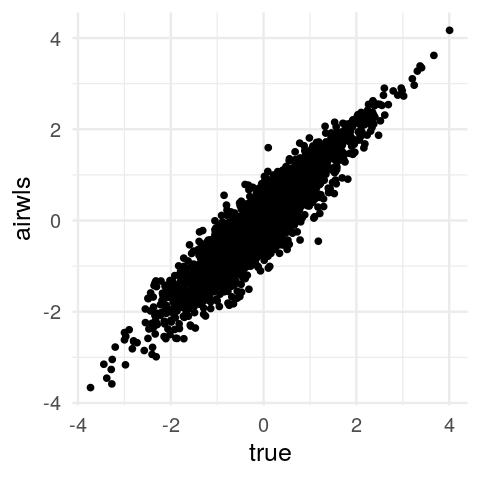

In [39]:
ggplot(experiments[[1]]$results, aes(x=true, y=airwls)) + geom_point()
cat("Alt GLMM correlation =",cor(c(experiments[[1]]$data$M),c(experiments[[1]]$M.gmf.airwls)))